<a href="https://colab.research.google.com/github/volk401/Deep-learning/blob/main/notebooks/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №4

# Задание



По заданию выбрать свои классы, загрузить предобученную модель по варианту, заморозить веса модели и провести дообучение на своих классах набора данных. Параметры аугментации использовать из лабораторной работы номер 3.

Сравнить результаты и качество обученных моделей для первых четырех лабораторных работ.

Отчет должен содержать: титульный лист, задание с вариантом, скриншоты и краткие пояснения по каждому этапу лабораторной работы, результаты дообучения модели после заморозки весов.

Варианты классов использовать из 1 лабораторной работы.

### Варианты предобученных моделей

|  Вариант   |  Модель   
|----------|----------|
|  Четный   | resnet20
|  Нечетный   | mobilenetv2_x0_5

# Задания для самостоятельной работы
1. Проведите обучение модели по вашему варианту с наилучшими параметрами аугментации из предыдущей лабораторной.
2. Проанализируйте результаты обучения вашей модели. Как изменилась точность на обучающей и тестовой выборке по сравнению с предыдущими моделями?
3. Сравните обучение модели с заморозкой и без заморозки весов.
4. Измените гиперпараметры обучения для повышения точности модели: количество эпох, размер батча, скорость обучения
5. Укажите, какие действия помогли повысить точность вашей модели и объясните почему.

# Контрольные вопросы для защиты
1. Что такое перенос обучения?
2. Опишите архитектуры предобученной модели вашего варианта
3. Что такое fine tunning? Что такое заморозка весов?
4. Метод оптимизации Adagrad
5. Метод оптимизации RMSProp
6. Метод оптимизации Adam


#Инициализация предобученной модели

In [1]:
#!pip install torchsummary
import time
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms as T
import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!nvidia-smi

Thu Mar 23 21:14:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz

--2023-03-23 21:14:31--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  13.6MB/s    in 13s     

2023-03-23 21:14:46 (12.1 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


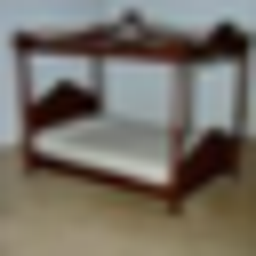

In [5]:
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
CLASSES = [5, 30, 55]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

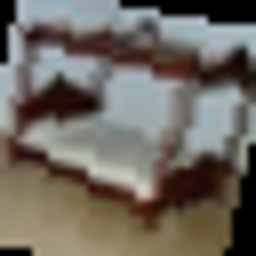

In [6]:
class CifarDataset(Dataset):
     def __init__(self, X, y, transform=None, p=0.0):
         assert X.size(0) == y.size(0)
         super(Dataset, self).__init__()
         self.X = X
         self.y = y
         self.transform = transform
         self.prob = p
        
     def __len__(self):
         return self.y.size(0)
        
     def __getitem__(self, index):
        x = self.X[index]
        if self.transform and np.random.random()<self.prob:
            x = self.transform(x.permute(2, 0, 1)/255.).permute(1, 2, 0)*255.
        y = self.y[index]
        return x, y

transform = T.Compose([
     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.0),
     T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2),
                    shear=5),
])

Image.fromarray((transform(torch.Tensor(train_X[50]).permute(2, 0, 1)/255.).\
                 permute(1, 2, 0).numpy()*255.).astype(np.uint8)).\
                 resize((256, 256))

In [35]:
batch_size = 128
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = CifarDataset(tensor_x, tensor_y,
                           transform if part=='train' else None,
                           p=0.5) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size,
                                  prefetch_factor=8 if part=='train' else 2,
                                  num_workers=2, persistent_workers=True,
                                  shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f2a62f6b160>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f2a62edb7c0>}

In [36]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2) # nhwc -> nm

class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)

class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.seq = nn.Sequential(
            Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),
            # первый способ уменьшения размерности картинки - через stride
            nn.Conv2d(3, HIDDEN_SIZE, 3, stride=4),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            # второй способ уменьшения размерности картинки - через слой пуллинг
            nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE*2, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(4),#nn.MaxPool2d(4),
            nn.Dropout2d(p=0.3),
            nn.Flatten(),
            nn.Linear(HIDDEN_SIZE*8, classes),
        )

    def forward(self, input):
        return self.seq(input)

model = torch.hub.load("chenyaofo/pytorch-cifar-models",
                       "cifar100_mobilenetv2_x0_5",
                       #'cifar100_resnet20',
                       pretrained=True)
model.to(device)
new_model = nn.Sequential(
    Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),# https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
    model
).to(device)
print(new_model(torch.rand(1, 32, 32, 3).to(device)))
summary(new_model, input_size=(32, 32, 3))
new_model

tensor([[-0.9223, -0.2393,  0.1066,  1.0439,  0.0741, -1.0146, -0.8419,  0.7759,
         -0.0113,  0.0503,  0.4350,  0.7716, -0.0108,  0.2205, -0.2536,  0.1383,
         -0.9537, -0.1603,  0.4309,  0.7944, -0.5017,  0.7123,  0.3097,  0.0316,
         -0.3386,  0.3071,  0.3332, -0.2339, -0.3890,  0.8370, -0.2517,  0.0310,
          0.6642,  0.5694, -0.1028,  0.0366,  0.2053,  0.6643,  0.1202, -0.1071,
          0.5000,  0.1992,  0.5018, -0.2516,  0.6745,  0.8451,  0.9990, -0.8434,
         -0.7528, -0.2528,  0.0814,  0.0411, -1.4496, -0.4765, -1.0423,  0.3396,
         -0.2077,  0.2817, -1.0784,  0.4278, -0.7941, -0.3558,  0.1908,  0.6618,
          0.4268,  0.3145,  0.4645,  1.1210, -0.1834,  0.1894, -0.7761, -0.9270,
          0.9698,  0.5473, -0.6434,  0.7496, -0.5300,  0.1417,  1.0912,  0.3443,
          0.0281, -1.5127,  0.1781, -0.5870,  0.1065,  0.2334, -0.7925,  0.7030,
          0.1754, -0.2193,  0.1456, -0.1077, -0.8461, -0.2207, -0.9365, -0.9548,
         -0.2104, -0.4977,  

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Sequential(
  (0): Normalize()
  (1): MobileNetV2(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(8, 48, kernel_size=(1, 1

In [37]:
summary(model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             432
       BatchNorm2d-2         [-1, 16, 512, 512]              32
             ReLU6-3         [-1, 16, 512, 512]               0
            Conv2d-4         [-1, 16, 512, 512]             144
       BatchNorm2d-5         [-1, 16, 512, 512]              32
             ReLU6-6         [-1, 16, 512, 512]               0
            Conv2d-7          [-1, 8, 512, 512]             128
       BatchNorm2d-8          [-1, 8, 512, 512]              16
  InvertedResidual-9          [-1, 8, 512, 512]               0
           Conv2d-10         [-1, 48, 512, 512]             384
      BatchNorm2d-11         [-1, 48, 512, 512]              96
            ReLU6-12         [-1, 48, 512, 512]               0
           Conv2d-13         [-1, 48, 512, 512]             432
      BatchNorm2d-14         [-1, 48, 5

In [38]:
#!git clone https://github.com/Fangyh09/pytorch-receptive-field.git
def compute_RF_numerical(net,img_np):
    '''
    @param net: Pytorch network
    @param img_np: numpy array to use as input to the networks, it must be full of ones and with the correct
    shape.
    '''
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.fill_(1)
            m.bias.data.fill_(0)
    #net.apply(weights_init)
    img_ = torch.tensor(torch.from_numpy(img_np).float(),requires_grad=True)
    out_cnn=net(img_.to(device))
    out_shape=out_cnn.size()
    ndims=len(out_cnn.size())
    grad=torch.zeros(out_cnn.size())
    l_tmp=[]
    for i in range(ndims):
        if i==0 or i ==1:#batch or channel
            l_tmp.append(0)
        else:
            l_tmp.append(out_shape[i]/2)
            
    grad[tuple(l_tmp)]=1
    out_cnn.backward(gradient=grad.to(device))
    grad_np=img_.grad[0,0].data.detach().cpu().numpy()
    idx_nonzeros=np.where(grad_np!=0)
    RF=[np.max(idx)-np.min(idx)+1 for idx in idx_nonzeros]
    
    return RF

compute_RF_numerical(model, np.zeros((1, 3, 1024, 1024)))

<ipython-input-38-0d0f494b73ca>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_ = torch.tensor(torch.from_numpy(img_np).float(),requires_grad=True)


[1024, 1024]

In [39]:
## mobilenetv2
in_features = new_model[1].classifier[1].in_features
new_model[1].classifier[1] = nn.Linear(in_features=in_features,
                                      out_features=len(CLASSES),
                                      bias=True)
## resnet20
# in_features = new_model[1].fc.in_features
# new_model[1].fc = nn.Linear(in_features=in_features,
#                             out_features=len(CLASSES),
#                             bias=True)

new_model.to(device)
summary(new_model, input_size=(32, 32, 3))
print(new_model(torch.rand(1, 32, 32, 3).to(device)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 32, 32]             432
       BatchNorm2d-3           [-1, 16, 32, 32]              32
             ReLU6-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]             144
       BatchNorm2d-6           [-1, 16, 32, 32]              32
             ReLU6-7           [-1, 16, 32, 32]               0
            Conv2d-8            [-1, 8, 32, 32]             128
       BatchNorm2d-9            [-1, 8, 32, 32]              16
 InvertedResidual-10            [-1, 8, 32, 32]               0
           Conv2d-11           [-1, 48, 32, 32]             384
      BatchNorm2d-12           [-1, 48, 32, 32]              96
            ReLU6-13           [-1, 48, 32, 32]               0
           Conv2d-14           [-1, 48,

# Заморозка весов

In [40]:
print("Обучаемые параметры:")
keep_last = 2
total = len([*new_model.named_parameters()])
params_to_update = []
for i, (name, param) in enumerate(new_model.named_parameters()):
    if i < total - keep_last:
        param.requires_grad = False 
    else:
        params_to_update.append(param)
        print("\t",name)
summary(new_model, input_size=(32, 32, 3))

Обучаемые параметры:
	 1.classifier.1.weight
	 1.classifier.1.bias
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 32, 32]             432
       BatchNorm2d-3           [-1, 16, 32, 32]              32
             ReLU6-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]             144
       BatchNorm2d-6           [-1, 16, 32, 32]              32
             ReLU6-7           [-1, 16, 32, 32]               0
            Conv2d-8            [-1, 8, 32, 32]             128
       BatchNorm2d-9            [-1, 8, 32, 32]              16
 InvertedResidual-10            [-1, 8, 32, 32]               0
           Conv2d-11           [-1, 48, 32, 32]             384
      BatchNorm2d-12           [-1, 48, 32, 32]              96
            ReLU6-13           [-1, 

# Fine tunning

In [41]:
# добавляем сглаживание целевых меток, это увеличит значение функции потерь
# но полученная модель будет более устойчивой к выбросам в обучающей выборке
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# используется SGD c momentum и L2-регуляризацией весов
optimizer = optim.SGD(params_to_update, lr=3e-4, momentum=0.9,
                      weight_decay=1e-5)
# добавляем постепенное уменьшение шага обучения каждые 200 эпох
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

Эпоха: 120
Лучшая доля правильных ответов: 93.5132573445638
Текущая доля правильных ответов: 92.02178192138672


  0%|          | 0/1440 [00:00<?, ?it/s]

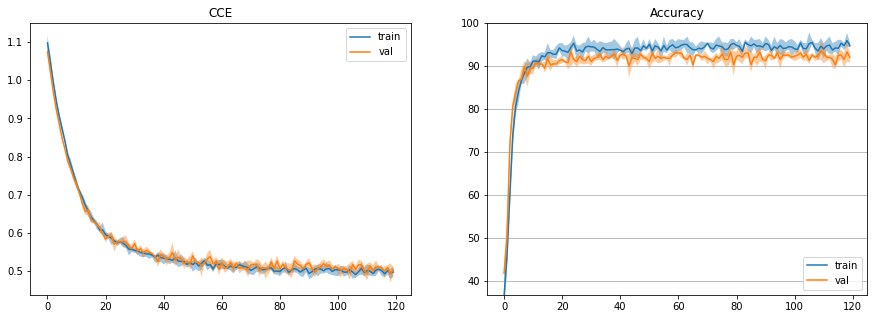

Обучение закончено за 108.14352035522461 секунд


In [42]:
EPOCHS = 60
REDRAW_EVERY = 10
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
# для создания чекпоинта
best_acc = 0
checkpoint_path = 'cifar_cnn_fine.pth' 
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    tmp = []
    new_model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = new_model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        accuracy = (labels.detach().argmax(dim=-1)==outputs.detach().argmax(dim=-1)).\
                    to(torch.float32).mean().cpu()*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    scheduler.step() # обновляем learning_rate каждую эпоху
    tmp = []
    new_model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = new_model(inputs)
            loss = criterion(outputs, labels)
            accuracy = (labels.argmax(dim=-1)==outputs.argmax(dim=-1)).\
                        to(torch.float32).mean().cpu()*100
            tmp.append((loss.item(), accuracy.item()))
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    # сохранение чекпоинта
    acc = losses_val[-1][0][1]
    if acc > best_acc:
        best_acc = acc
        torch.save(new_model.state_dict(), checkpoint_path)
    # обновление графиков
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    print('Эпоха: %s\n'
          'Лучшая доля правильных ответов: %s\n'
          'Текущая доля правильных ответов: %s' % (epoch+1, best_acc, acc))
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
new_model.load_state_dict(torch.load(checkpoint_path))
print('Обучение закончено за %s секунд' % passed)

In [43]:
batch_size = 128
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = CifarDataset(tensor_x, tensor_y,
                           transform=None,
                           p=0.0) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size,
                                  num_workers=2, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f2a6311f0d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f2a6354d280>}

In [44]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data
             # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = new_model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

           5     0.9862    1.0000    0.9930       500
          30     0.9898    0.9660    0.9777       500
          55     0.9683    0.9780    0.9731       500

    accuracy                         0.9813      1500
   macro avg     0.9814    0.9813    0.9813      1500
weighted avg     0.9814    0.9813    0.9813      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

           5     0.9519    0.9900    0.9706       100
          30     0.8774    0.9300    0.9029       100
          55     0.9444    0.8500    0.8947       100

    accuracy                         0.9233       300
   macro avg     0.9246    0.9233    0.9227       300
weighted avg     0.9246    0.9233    0.9227       300

--------------------------------------------------


In [ ]:
# сохраниение модели
# ПЕРВЫЙ СПОСОБ: сохранение параметров
PATH = 'cifar_cnn_fine.pth'
torch.save(new_model.state_dict(), PATH)

# ВТОРОЙ СПОСОБ: сохранение всей архитектуры
PATH2 = 'cifar_cnn_fine.pt'
torch.save(new_model, PATH2)
# загрузка
new_model_2 = torch.load(PATH2)
new_model_2.eval()

Sequential(
  (0): Normalize()
  (1): CifarResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): 

In [ ]:
class GlobalAvgPooling2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPooling2d, self).__init__()

    def forward(self, x):
        x = F.adaptive_avg_pool2d(x, (1, 1))
        return torch.flatten(x, 1)

class MyModel(nn.Module):

    def __init__(self, model):
        super(MyModel, self).__init__()

        # Here you get the bottleneck/feature extractor
        self.normalization = model[0]
        self.resnet_feature_extractor = \
                nn.Sequential(*list(model[1].children())[:-1])

        # Now you can include your classifiers
        self.classifier = list(model[1].children())[-1]

    # Set your own forward pass
    def forward(self, x, extra_info=None):
        x = self.normalization(x)
        x = self.resnet_feature_extractor(x)
        x = self.classifier(x)
        return x

new_model = torch.load(PATH2)
new_model[1].avgpool = GlobalAvgPooling2d()
new_model.to(device)
model = MyModel(new_model).to(device)

summary(model, input_size=(32, 32, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 32, 32]             432
       BatchNorm2d-3           [-1, 16, 32, 32]              32
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
             ReLU-10           [-1, 16, 32, 32]               0
       BasicBlock-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 16, 32, 32]           2,304
      BatchNorm2d-13           [-1, 16, 32, 32]              32
             ReLU-14           [-1, 16,

In [ ]:
# входной тензор для модели
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100_CNN_RESNET20.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})